# LSTM on weather data

Adapted from https://www.tensorflow.org/tutorials/structured_data/time_series

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
import seaborn as sns

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
tf.random.set_seed(42)

In [5]:
from scipy import stats
import os
import sys
import pathlib

pd.set_option("display.precision", 2)

In [6]:
from sklearn.metrics import mean_squared_error

In [7]:
path = 'data/weather/'

In [8]:
# data files
file_x_train = "x_train.csv"
file_x_val = "x_val.csv"
file_x_test = "x_test.csv"
file_y_train = "y_train.csv"
file_y_val = "y_val.csv"
file_y_test = "y_test.csv"

In [9]:
x_train = pd.read_csv(f'{path}{file_x_train}', index_col=0)
x_val = pd.read_csv(f'{path}{file_x_val}', index_col=0)
x_test = pd.read_csv(f'{path}{file_x_test}', index_col=0)

y_train = pd.read_csv(f'{path}{file_y_train}', index_col=0).iloc[:,0]
y_val = pd.read_csv(f'{path}{file_y_val}', index_col=0).iloc[:,0]
y_test = pd.read_csv(f'{path}{file_y_test}', index_col=0).iloc[:,0]

In [10]:
x_train.shape, x_val.shape, x_test.shape

((49063, 7), (14018, 7), (7010, 7))

In [11]:
y_train.shape, y_val.shape, y_test.shape

((49063,), (14018,), (7010,))

### TF Timeseries Dataset for LSTM inputs

In [12]:
# adding label at the end
output_train = x_train.copy()
output_val = x_val.copy()
output_test = x_test.copy()

output_train["label"] = y_train
output_val["label"] = y_val
output_test["label"] = y_test

In [13]:
output_train.head(10)

,Year sin,Day sin,Day cos,p (mbar),wd (deg),wv (m/s),max. wv (m/s),label
5,-0.06,0.37,1.37e+00,0.95,0.22,-1.27,-1.26,-8.05
11,-0.06,0.71,1.22e+00,0.96,0.19,-1.24,-1.26,-8.88
17,-0.06,1.00,1.00e+00,0.99,-0.07,-1.29,-1.26,-8.81
23,-0.06,1.22,7.07e-01,1.00,0.76,-1.34,-1.37,-9.05
29,-0.06,1.37,3.66e-01,1.06,-0.19,-1.14,-1.16,-9.63
35,-0.06,1.41,1.02e-04,1.09,-0.31,-1.37,-1.32,-9.67
41,-0.05,1.37,-3.66e-01,1.17,2.00,-0.05,-0.29,-9.17
47,-0.05,1.22,-7.07e-01,1.27,0.46,-0.93,-1.00,-8.10
53,-0.05,1.00,-1.00e+00,1.33,0.33,-1.18,-1.26,-7.66
59,-0.05,0.71,-1.22e+00,1.40,1.36,-0.46,-0.24,-7.04


In [14]:
# LSTM parameters
window_size = 7
n_features = x_train.shape[1]

In [15]:
# train
data_train = np.array(output_train.iloc[:,:-1], dtype=np.float32)
labels_train = np.array(output_train.iloc[:,-1:], dtype=np.float32)
# no shift in labels
ds_train = tf.keras.utils.timeseries_dataset_from_array(
    data = data_train,
    targets = labels_train,
    sequence_length = window_size,
    sequence_stride = 1,
    shuffle = False,
    batch_size = 32)

# val
data_val = np.array(output_val.iloc[:,:-1], dtype=np.float32)
labels_val = np.array(output_val.iloc[:,-1:], dtype=np.float32)
# no shift in labels
ds_val = tf.keras.utils.timeseries_dataset_from_array(
    data=data_val,
    targets=labels_val,
    sequence_length = window_size,
    sequence_stride=1,
    shuffle=False,
    batch_size= 32)

#test
data_test = np.array(output_test.iloc[:,:-1], dtype=np.float32)
labels_test = np.array(output_test.iloc[:,-1:], dtype=np.float32)
# no shift in labels
ds_test = tf.keras.utils.timeseries_dataset_from_array(
    data=data_test,
    targets=labels_test,
    sequence_length = window_size,
    sequence_stride=1,
    shuffle=False,
    batch_size= 32)

In [16]:
batch_inputs = {}
batch_labels = {}

In [17]:
i = 0
for batch in ds_train:
    batch_inputs[i], batch_labels[i] = batch
    i = i+1

### Checking if the sequence is right

In [18]:
batch_inputs[0][0][0]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([-0.06105236,  0.36611056,  1.3660688 ,  0.9453076 ,  0.22183082,
       -1.2668532 , -1.2638713 ], dtype=float32)>

In [19]:
data_train[0,:]

array([-0.06105236,  0.36611056,  1.3660688 ,  0.9453076 ,  0.22183082,
       -1.2668532 , -1.2638713 ], dtype=float32)

In [20]:
batch_labels[0][:7]

<tf.Tensor: shape=(7, 1), dtype=float32, numpy=
array([[-8.05],
       [-8.88],
       [-8.81],
       [-9.05],
       [-9.63],
       [-9.67],
       [-9.17]], dtype=float32)>

In [21]:
labels_train[:7]

array([[-8.05],
       [-8.88],
       [-8.81],
       [-9.05],
       [-9.63],
       [-9.67],
       [-9.17]], dtype=float32)

### Model Fitting

In [22]:
# model fitting
model = Sequential()
model.add(LSTM(64, input_shape=(total_window_size, n_features)))
model.add(Dense(1))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=8,
                                                    mode='min')

model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

num_epochs = 100
model.fit(ds_train, epochs=num_epochs, validation_data=ds_val, callbacks=[early_stopping])

Epoch 1/100
1534/1534 [==============================] - 11s 5ms/step - loss: 62.6218 - mean_absolute_error: 6.3834 - val_loss: 64.3978 - val_mean_absolute_error: 6.6311
Epoch 2/100
1534/1534 [==============================] - 7s 5ms/step - loss: 75.6579 - mean_absolute_error: 7.1767 - val_loss: 69.0684 - val_mean_absolute_error: 7.0003
Epoch 3/100
1534/1534 [==============================] - 7s 5ms/step - loss: 71.8895 - mean_absolute_error: 7.0229 - val_loss: 59.4322 - val_mean_absolute_error: 6.3970
Epoch 4/100
1534/1534 [==============================] - 7s 5ms/step - loss: 68.5303 - mean_absolute_error: 6.8555 - val_loss: 57.3441 - val_mean_absolute_error: 6.2211
Epoch 5/100
1534/1534 [==============================] - 7s 5ms/step - loss: 67.2749 - mean_absolute_error: 6.7714 - val_loss: 54.4764 - val_mean_absolute_error: 6.0093
Epoch 6/100
1534/1534 [==============================] - 7s 5ms/step - loss: 64.2383 - mean_absolute_error: 6.5997 - val_loss: 54.5529 - val_mean_absolute

In [ ]:
pred = model.predict(ds_test)

In [23]:
# Putting labels in a numpy array
all_labels = []
for batch in ds_test:
    inputs, labels = batch
    all_labels.append(labels)

all_labels = tf.concat(all_labels, axis=0).numpy()

In [25]:
compare = pd.DataFrame(data=all_labels, columns=["labels"])
compare["predict"] = pred

In [40]:
compare.iloc[-10:]

,labels,predict
6994,-6.84,-4.39
6995,-6.31,-3.65
6996,-5.02,-2.98
6997,-3.31,-1.67
6998,-0.71,1.88
6999,1.97,3.44
7000,4.15,3.95
7001,4.97,3.45
7002,2.44,5.08
7003,1.29,4.57


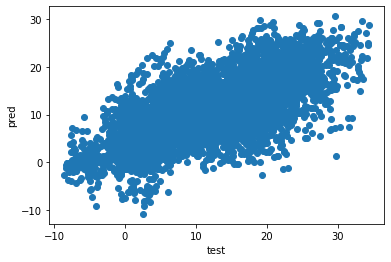

In [27]:
plt.scatter(all_labels, pred)
plt.xlabel("test")
plt.ylabel("pred")
plt.show()

In [28]:
def print_stats(y, pred):
    
    rmse = np.sqrt(mean_squared_error(y, pred))
    pearson_coef, p_value = stats.pearsonr(y, pred)
    # na_count = y.isna().astype(int).sum() + pd.Series(pred).isna().astype(int).sum()
    
    return rmse, pearson_coef, p_value

In [32]:
pred_train = model.predict(ds_train)
pred_val = model.predict(ds_val)

In [33]:
all_labels_train = []
for batch in ds_train:
    inputs, labels = batch
    all_labels_train.append(labels)

all_labels_train = tf.concat(all_labels_train, axis=0).numpy()

In [38]:
all_labels_val = []
for batch in ds_val:
    inputs, labels = batch
    all_labels_val.append(labels)

all_labels_val = tf.concat(all_labels_val, axis=0).numpy()

In [35]:
print_stats(pd.Series(all_labels[:,0]), pred)

(5.9273086, array([0.6667969923385437], dtype=object), 0.0)

In [39]:
print_stats(pd.Series(all_labels_val[:,0]), pred_val)

(6.433591, array([0.5845823182651385], dtype=object), 0.0)

In [36]:
print_stats(pd.Series(all_labels_train[:,0]), pred_train)

(5.6764474, array([0.7708411409388707], dtype=object), 0.0)